# 1. Import and Install Dependencies

In [2]:
# tracking stuff
!pip install  opencv-python mediapipe sklearn matplotlib 
#tensorflow-gpu==2.4.1
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# sound stuff
!pip install pyaudio
!pip install pysinewave
import time
import pyaudio
from pysinewave import SineWave
import pyaudio as p
import math

# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                          ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

this is for the frequency stuff

In [4]:
def pitch_to_freq(pitch):
    return 440 * 2 ^ ((pitch-9)/12)

def freq_to_pitch(freq):
    return 12 * math.log2(freq/440) + 9

# CHORDS = {
#     0   : [-10, -6, -4],
#     0.1 : [-7, -4, -2],
#     0.2 : [-5, -2, 1],
#     0.3 : [-3, 1, 3],
#     0.4 : [-1, 3, 5],
#     0.5 : [0, 4, 7],
#     0.6 : [2, 5, 9],
#     0.7 : [3, 7, 10],
#     0.8 : [5, 9, 12],
#     0.9 : [7, 11, 14],
#     1   : [9, 13, 16]
# }

CHORDS = {
    0   : [-6, -2, 1],
    0.1 : [-5, -1, 2],
    0.2 : [-4, 0, 3],
    0.3 : [-2, 2, 5],
    0.4 : [-1, 3, 6],
    0.5 : [0, 4, 7],
    0.6 : [0.5, 5, 8],
    0.7 : [2, 6, 9],
    0.8 : [4, 8, 11],
    0.9 : [5, 9, 12],
    1   : [6, 10, 13]
}



class Waves:
    def __init__(self):
        self.wave1 = SineWave(pitch=0, pitch_per_second=50)
        self.wave2 = SineWave(pitch=4, pitch_per_second=50)
        self.wave3 = SineWave(pitch=7, pitch_per_second=50)
        self.waves = [self.wave1, self.wave2, self.wave3]

    def get_chords(self, x_pos):
        chord = [0, 4, 7]
        offset = 2
        difference = x_pos - 0.5

        new_chord = []
        for c in chord:
            new_chord.append(c + (difference*10) * offset)

        return new_chord

    def update_chord(self, x_pos):
        pitches = CHORDS[x_pos]
        for i in range(3):
            self.waves[i].set_pitch(pitches[i])

        self.run()

    def run(self):
        for wave in self.waves:
            wave.play()
        # time.sleep(1.5) # Comment out when done

    def stop(self):
        for wave in self.waves:
            wave.stop()

this runs the video feed

In [5]:
cap = cv2.VideoCapture(0)
# get height and width of screen
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# wave = Waves()
# wave.run()

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    y_pos = 0
    x_pos = 0

    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)

        # from results find left hand position and caalculate what pitch to play
        
        # if results.left_hand_landmarks != None:
        #     left_pos = results.left_hand_landmarks.landmark[0]
        #     y_pos = left_pos.y
        # if results.right_hand_landmarks != None:
        #     right_pos = results.right_hand_landmarks.landmark[0]
        #     x_pos = right_pos.x
            
            # range 0 to 50
            # volume = y_pos * 50
            # wave.set_volume(volume)

            # range -10 to 10
            # x_pos = 1 - x_pos
            # x_pos = round(x_pos, 1)
            # wave.update_chord(x_pos)
            
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    # wave.stop()
    cv2.destroyAllWindows()

In [18]:
cap.release()

In [6]:
draw_landmarks(frame, results)

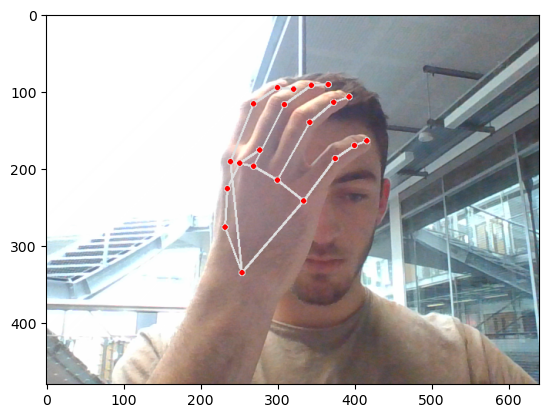

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [9]:
len(results.right_hand_landmarks.landmark)


21

In [10]:
def extract_keypoints(results):
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    # pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    # rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    # return np.concatenate([pose, face, lh, rh])
    # return np.concatenate([lh, rh])
    return lh

In [13]:
result_test = extract_keypoints(results)

In [14]:
result_test.shape

(126,)

In [17]:
np.save('0', result_test)

In [18]:
np.load('0.npy')

array([ 0.46479714,  0.47042787, -0.03023029, ...,  0.53018653,
        0.32886922,  0.0141443 ])

# 4. Setup Folders for Collection

In [15]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
# actions = np.array(['hello', 'thanks', 'iloveyou'])
actions = np.array(['index', 'middle'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
# start_folder = 30

In [16]:
for action in actions: 
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(0,no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [17]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        cv2.waitKey(5000)
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    # cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'index': 0, 'middle': 1}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

(60, 30, 126)

In [ ]:
np.array(labels).shape

(80,)

In [23]:
X = np.array(sequences)

In [24]:
X.shape

(60, 30, 126)

In [25]:
y = to_categorical(labels).astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [27]:
y_test.shape

(3, 2)

In [28]:
X = X[:,:30,:]
print(X.shape)

(60, 30, 126)


# 7. Build and Train LSTM Neural Network

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [30]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [31]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
2/2 [==============================] - 3s 36ms/step - loss: 0.6945 - categorical_accuracy: 0.5088
Epoch 2/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.6924 - categorical_accuracy: 0.5088
Epoch 3/2000
2/2 [==============================] - 0s 26ms/step - loss: 0.6944 - categorical_accuracy: 0.4386
Epoch 4/2000
2/2 [==============================] - 0s 28ms/step - loss: 0.6909 - categorical_accuracy: 0.4561
Epoch 5/2000
2/2 [==============================] - 0s 26ms/step - loss: 0.6872 - categorical_accuracy: 0.5439
Epoch 6/2000
2/2 [==============================] - 0s 29ms/step - loss: 0.6838 - categorical_accuracy: 0.5614
Epoch 7/2000
2/2 [==============================] - 0s 27ms/step - loss: 0.6729 - categorical_accuracy: 0.5789
Epoch 8/2000
2/2 [==============================] - 0s 27ms/step - loss: 0.6658 - categorical_accuracy: 0.6491
Epoch 9/2000
2/2 [==============================] - 0s 29ms/step - loss: 0.6659 - categorical_accuracy: 0.6316
E

KeyboardInterrupt: 

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            48896     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 203,426
Trainable params: 203,426
Non-trai

# 8. Make Predictions

In [35]:
res = model.predict(X_test)

1/1 [==============================] - 0s 237ms/step


In [39]:
print(y_test)

[[1 0]
 [1 0]
 [0 1]]


In [42]:
actions[np.argmax(res[2])]

'middle'

In [ ]:
actions[np.argmax(y_test[])]

'speaking'

# 9. Save Weights

In [43]:
model.save('test_model.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [44]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [45]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 18ms/step


In [46]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [47]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 2]],

       [[2, 0],
        [0, 1]]], dtype=int64)

In [48]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [49]:
from scipy import stats

In [50]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [51]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [53]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti